In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch

from text_clustering import TextClustering
from utils.training_and_visualisation import plot_losses

%matplotlib inline


PATH = "embeds/"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

embs_train = torch.load(PATH + "t5_train.pt")
embs_test = torch.load(PATH + "t5_test.pt")


PATH = "../dialogue_data/banking77/"

data_train = pd.read_csv(PATH + "train.csv", sep=",")
texts_train = data_train["text"].to_list()

data_train["cluster"] = data_train["category"].astype("category")
data_train["cluster"] = data_train["cluster"].cat.codes

clusters_train = data_train["cluster"].to_list()

data_test = pd.read_csv(PATH + "test.csv", sep=",")
texts_test = data_test["text"].to_list()

data_test["cluster"] = data_test["category"].astype("category")
data_test["cluster"] = data_test["cluster"].cat.codes

clusters_test = data_test["cluster"].to_list()

data_all = pd.concat((data_train, data_test)).reset_index() # fix indices
clusters_all = clusters_train + clusters_test

# load embeddings
embeds_t5_train = torch.load(PATH + "embeds/t5_train.pt")
embeds_t5_test = torch.load(PATH + "embeds/t5_test.pt")

embeds_t5_all = torch.vstack((embeds_t5_train, embeds_t5_test))
clusters_all = clusters_train + clusters_test

embeds_t5_train.shape, embeds_t5_test.shape


def sample_clusters(dataframe, raw_embeds, cluster_num_list, noise_cluster_num_list, noise_frac=0.):
    target_idxs = dataframe[dataframe["cluster"].isin(cluster_num_list)].index.to_list()
    target_size = len(target_idxs)
    target_data = dataframe.loc[target_idxs]
    target_embeds = raw_embeds[target_idxs]
    target_clusters = target_data["cluster"].to_list()
                
    if noise_frac != 0. and noise_cluster_num_list is not None:
        non_target_idxs = dataframe[dataframe["cluster"].isin(noise_cluster_num_list)].index.to_list()
        noise_data_all = dataframe.loc[non_target_idxs]

        noise_num = int(noise_frac * target_size)
        noise_idxs = list(np.random.choice(non_target_idxs, noise_num, replace=False))
        noise_data = dataframe.loc[noise_idxs]
        noise_embeds = raw_embeds[noise_idxs]
        noise_clusters = noise_data["cluster"].to_list()
        subset_data = pd.concat((target_data, noise_data))
        subset_clusters = target_clusters + noise_clusters
        subset_embeds = torch.vstack((target_embeds, noise_embeds))
        subset_idxs = target_idxs + noise_idxs
     
        return subset_embeds, subset_idxs, subset_data, subset_clusters, target_idxs
    
    return target_embeds, target_idxs, target_data, target_clusters, target_idxs


base_embeds, base_idxs, base_data, base_clusters, base_idxs_pure = sample_clusters(
    dataframe=data_all,
    raw_embeds=embeds_t5_all,
    cluster_num_list=[0, 1, 2, 3, 4],
    noise_cluster_num_list=None,
    noise_frac=0
)

cuda


In [8]:
n_classes = 5
inp_dim = 1024
feat_dim = 2
model = TextClustering(n_classes, inp_dim, feat_dim, base_embeds)

In [3]:
losses1, losses2 = model.fit(base_embeds)

Phase 1: train embeddings


  0%|          | 0/10 [00:00<?, ?it/s]

Phase 2: train clusters


  0%|          | 0/5 [00:00<?, ?it/s]

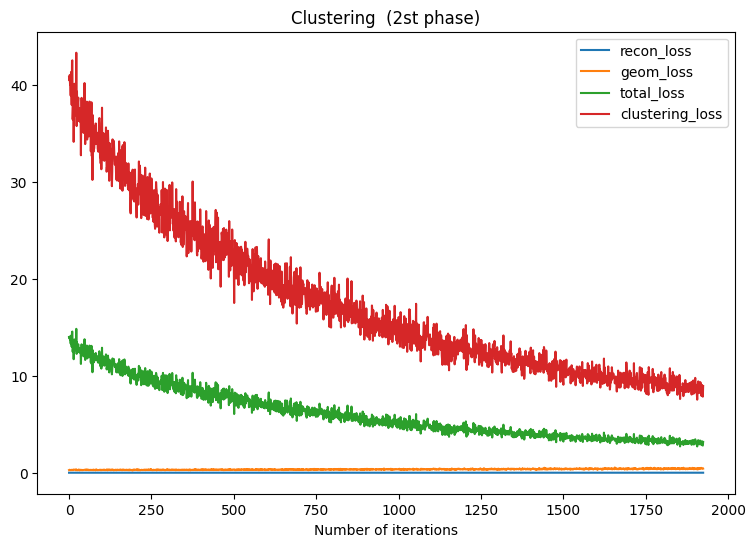

In [9]:
plot_losses(losses2, "Clustering  (2st phase)")

In [4]:
umap_embeds, pred_clusters = model.transform_and_cluster(base_embeds)

In [5]:
topics = model.get_topics(base_data['text'].to_list(), base_embeds)

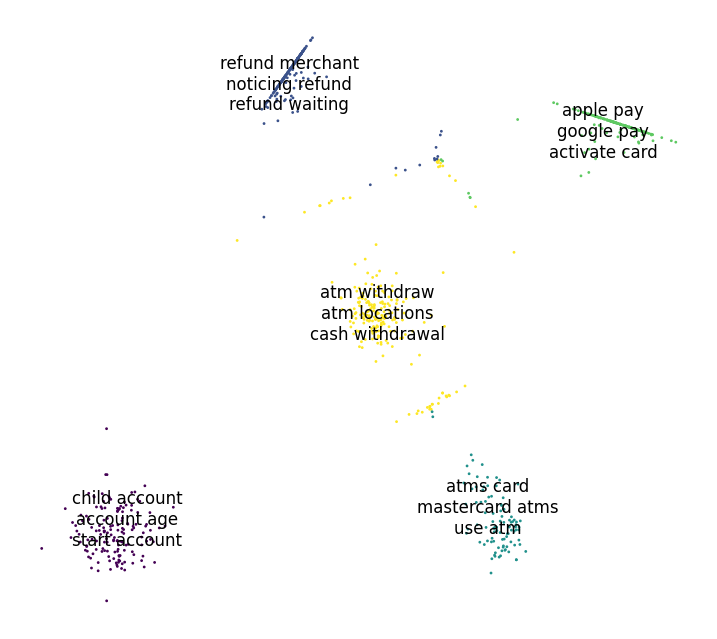

In [6]:
#umap_embeds = model.transform(base_embeds.to(device), batch_size=128)
new_centers = model.get_centers()
_, pred_clusters = model.transform_and_cluster(base_embeds.to(device))
plt.figure(figsize=(9, 9))
plt.scatter(*umap_embeds.T, c=pred_clusters, s=1.0)
#plt.scatter(*new_umap_embeds.T, c=base_clusters, s=1.0)
for i, (x, y) in enumerate(new_centers):
    plt.text(x, y, "\n".join(topics[i]), 
             horizontalalignment='center', 
             verticalalignment='center', 
             fontsize=12)# backgroundcolor='white')
plt.gca().set_aspect("equal")
plt.axis("off")
#plt.title("Parametric UMAP for Banking77")
#plt.legend()
plt.show()